In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Robot leg configuration
upper_leg_length = 10.0
lower_leg_length = 10.0

body_length = 21.0
body_width = 15.8
max_height = 15.0

# Shoulder positions (static)
shoulder_positions = np.asfortranarray([
    [body_length / 2, body_length / 2, -body_length / 2, -body_length / 2],
    [-body_width / 2, body_width / 2, -body_width / 2, body_width / 2],
    [0, 0, 0, 0],
])



In [2]:

def inverse_kinematics(x: float, y: float, z: float, a1: float=upper_leg_length, a2: float=lower_leg_length):
    y_prime = -math.sqrt((z)**2 + y**2)
    thetaz = math.atan2(abs(y), z)

    c2 = (x**2 + y_prime**2 - a1**2 - a2**2) / (2 * a1 * a2)
    s2 = math.sqrt(abs(1 - c2**2))
    theta2 = math.atan2(s2, c2)

    c1 = (x * (a1 + (a2 * c2)) + y_prime * (a2 * s2)) / (x**2 + y_prime**2)
    s1 = (y_prime * (a1 + (a2 * c2)) - x * (a2 * s2)) / (x**2 + y_prime**2)
    theta1 = math.atan2(s1, c1)

    theta_shoulder = -theta1
    theta_elbow = theta_shoulder - theta2
    theta_hip = thetaz

    return math.degrees(theta_shoulder), math.degrees(theta_elbow), math.degrees(theta_hip)


In [3]:

def compensate_foot_positions_by_gyro(np_foot_positions, roll, pitch):
    roll_rad = math.radians(roll)
    pitch_rad = math.radians(pitch)
    body_normal = np.array([
        math.sin(roll_rad),
        -math.sin(pitch_rad) * math.cos(roll_rad),
        math.cos(pitch_rad) * math.cos(roll_rad)
    ])

    base_correction = 0.8
    severity = max(
        min(abs(roll) / 45.0, 1.0),
        min(abs(pitch) / 45.0, 1.0)
    )
    correction_factor = base_correction * (1.0 + severity)

    max_compensation = 3.0
    max_leg_extension_y = -max_height * 1.2
    min_leg_extension_y = -max_height * 0.5

    compensated_positions = np_foot_positions.copy()
    for i in range(4):
        dx = shoulder_positions[0, i]
        dy = shoulder_positions[1, i]
        height_adj = (dx * body_normal[0] + dy * body_normal[1]) * correction_factor
        height_adj = np.clip(height_adj, -max_compensation, max_compensation)

        new_height = compensated_positions[2, i] - height_adj
        if new_height < max_leg_extension_y:
            height_adj = compensated_positions[2, i] - max_leg_extension_y
        elif new_height > min_leg_extension_y:
            height_adj = compensated_positions[2, i] - min_leg_extension_y

        compensated_positions[2, i] -= height_adj

    return compensated_positions


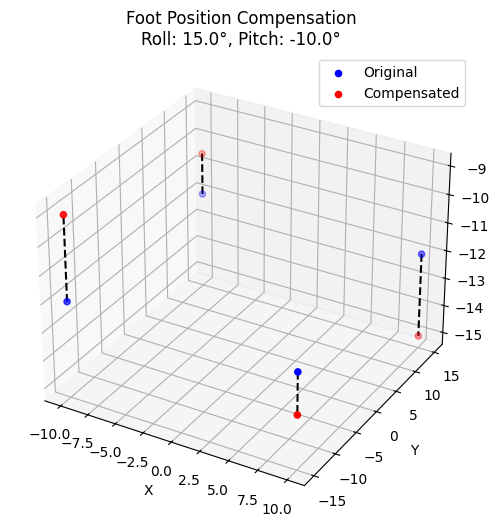

In [4]:

# Synthetic flat stance
original_positions = np.array([
    [ 10.0,  10.0, -10.0, -10.0],  # x
    [-15.0,  15.0, -15.0,  15.0],  # y
    [-12.0, -12.0, -12.0, -12.0]   # z
])

# Simulate gyro data
roll_angle = 15.0
pitch_angle = -10.0

compensated = compensate_foot_positions_by_gyro(original_positions, roll=roll_angle, pitch=pitch_angle)

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*original_positions, color='blue', label='Original')
ax.scatter(*compensated, color='red', label='Compensated')

for i in range(4):
    ax.plot([original_positions[0, i], compensated[0, i]],
            [original_positions[1, i], compensated[1, i]],
            [original_positions[2, i], compensated[2, i]], 'k--')

ax.set_title(f"Foot Position Compensation\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.show()


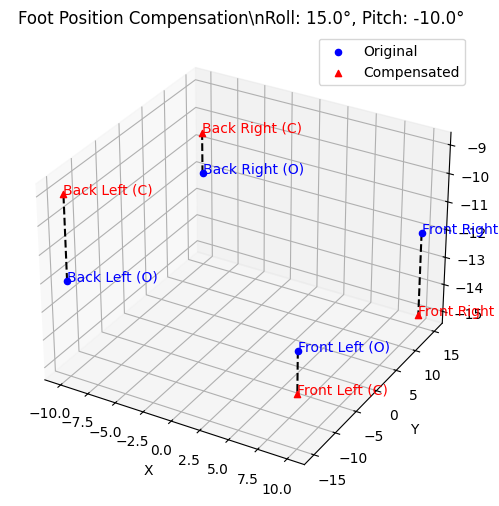

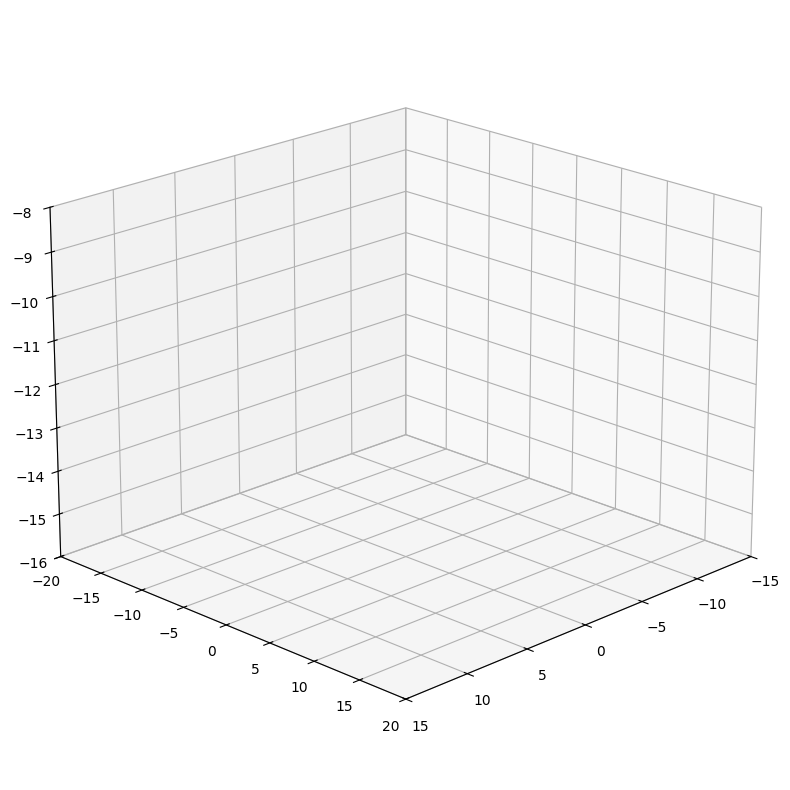

In [8]:
# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Colors for each leg
colors = ['blue', 'green', 'purple', 'orange']
labels = ['Front Left', 'Front Right', 'Back Left', 'Back Right']

# Plot each leg's original and compensated point
for i in range(4):
    ax.scatter(original_positions[0, i], original_positions[1, i], original_positions[2, i],
               color='blue', label='Original' if i == 0 else "", marker='o')
    ax.scatter(compensated[0, i], compensated[1, i], compensated[2, i],
               color='red', label='Compensated' if i == 0 else "", marker='^')

    # Connect with dashed line
    ax.plot([original_positions[0, i], compensated[0, i]],
            [original_positions[1, i], compensated[1, i]],
            [original_positions[2, i], compensated[2, i]],
            'k--')

    # Add labels
    ax.text(original_positions[0, i], original_positions[1, i], original_positions[2, i],
            f"{labels[i]} (O)", color='blue')
    ax.text(compensated[0, i], compensated[1, i], compensated[2, i],
            f"{labels[i]} (C)", color='red')

ax.set_title(f"Foot Position Compensation\\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-15, 15)
ax.set_ylim(-20, 20)
ax.set_zlim(-16, -8)
ax.view_init(elev=20, azim=45)
ax.grid(True)
plt.tight_layout()
plt.show()

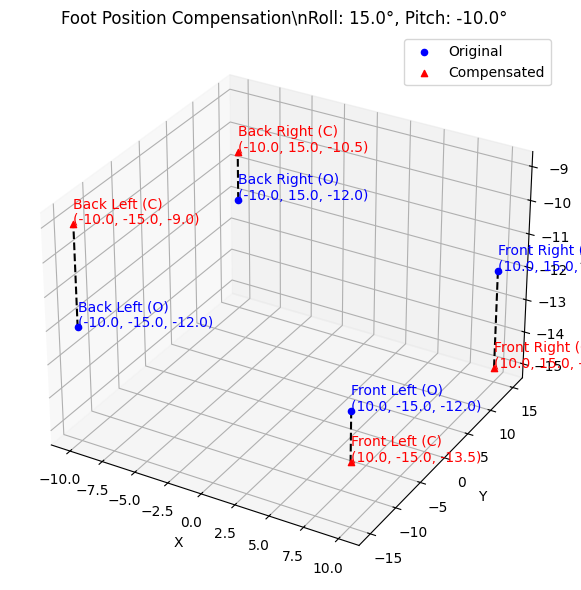

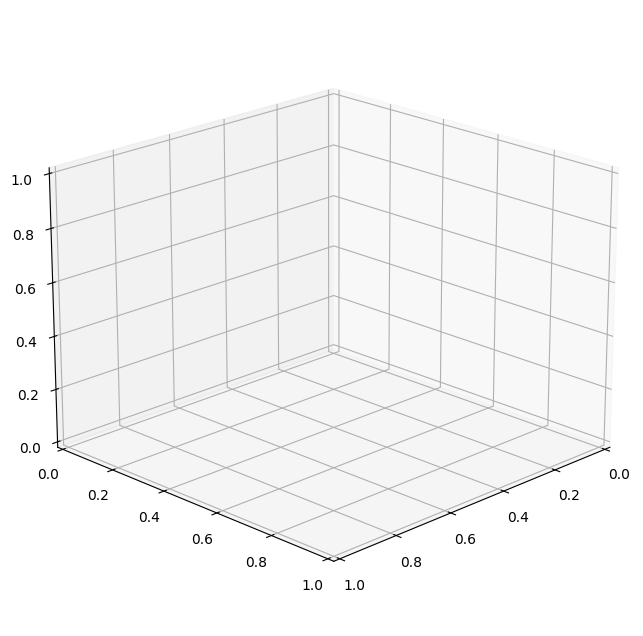

In [18]:
# Plotting
fig = plt.figure(figsize=(20, 6))
ax.view_init(elev=40, azim=1)  # Adjust elevation and azimuth
ax = fig.add_subplot(111, projection='3d')

# Colors for each leg
colors = ['blue', 'green', 'purple', 'orange']
labels = ['Front Left', 'Front Right', 'Back Left', 'Back Right']

# Plot each leg's original and compensated point
for i in range(4):
    # Original point
    ox, oy, oz = original_positions[:, i]
    ax.scatter(ox, oy, oz, color='blue', label='Original' if i == 0 else "", marker='o')
    ax.text(ox, oy, oz, f"{labels[i]} (O)\n({ox:.1f}, {oy:.1f}, {oz:.1f})", color='blue')

    # Compensated point
    cx, cy, cz = compensated[:, i]
    ax.scatter(cx, cy, cz, color='red', label='Compensated' if i == 0 else "", marker='^')
    ax.text(cx, cy, cz, f"{labels[i]} (C)\n({cx:.1f}, {cy:.1f}, {cz:.1f})", color='red')

    # Dashed line between original and compensated
    ax.plot([ox, cx], [oy, cy], [oz, cz], 'k--')

# Labels and settings
ax.set_title(f"Foot Position Compensation\\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.tight_layout()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=45)
plt.show()

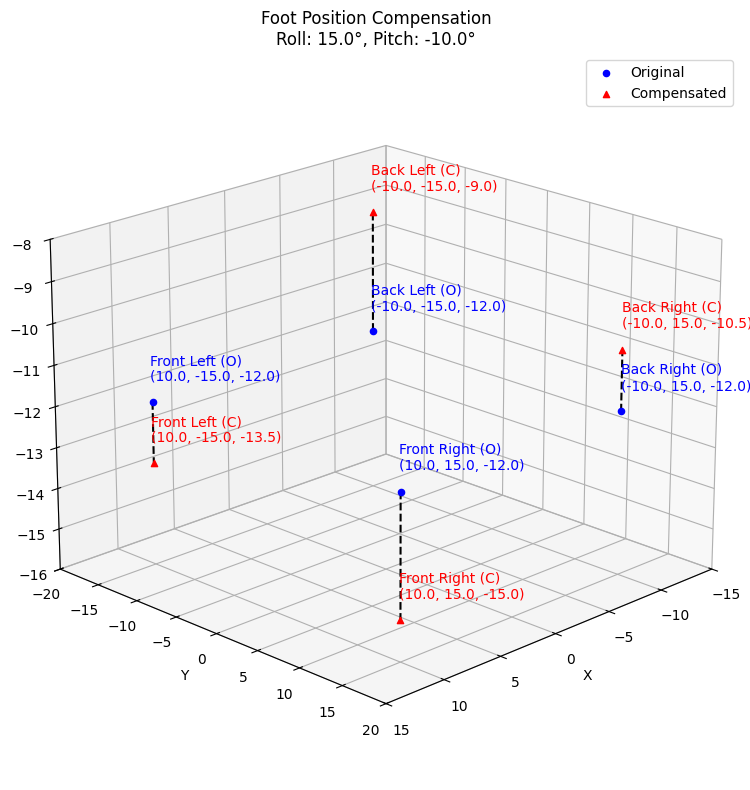

In [19]:
# === Apply gyro compensation ===
roll_angle = 15.0
pitch_angle = -10.0
compensated = compensate_foot_positions_by_gyro(original_positions, roll=roll_angle, pitch=pitch_angle)

# === Plotting ===
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set custom axis limits and view angle
ax.set_xlim(-15, 15)
ax.set_ylim(-20, 20)
ax.set_zlim(-16, -8)
ax.view_init(elev=20, azim=45)

# Leg labels
labels = ['Front Left', 'Front Right', 'Back Left', 'Back Right']
offset = 0.6

# Plot all four legs
for i in range(4):
    ox, oy, oz = original_positions[:, i]
    cx, cy, cz = compensated[:, i]

    # Plot original and compensated points
    ax.scatter(ox, oy, oz, color='blue', marker='o', label='Original' if i == 0 else "")
    ax.scatter(cx, cy, cz, color='red', marker='^', label='Compensated' if i == 0 else "")

    # Connect with a dashed line
    ax.plot([ox, cx], [oy, cy], [oz, cz], 'k--')

    # Label with coordinates
    ax.text(ox + offset, oy + offset, oz + offset, f"{labels[i]} (O)\n({ox:.1f}, {oy:.1f}, {oz:.1f})", color='blue')
    ax.text(cx + offset, cy + offset, cz + offset, f"{labels[i]} (C)\n({cx:.1f}, {cy:.1f}, {cz:.1f})", color='red')

# Final decorations
ax.set_title(f"Foot Position Compensation\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()